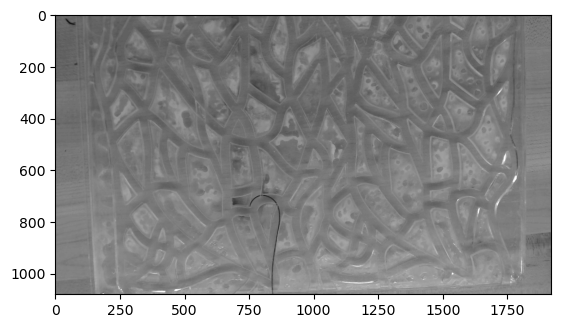

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

image = cv2.imread("../../Data/Datasets/RigidModelVideo-11-21/11-21-1-clip2/frame0478.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(image, cmap='gray')

(256, 1)


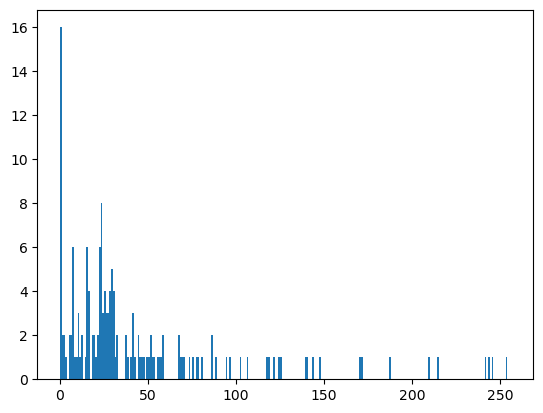

In [2]:
hst = cv2.calcHist([image], [0], None, [256], [0, 256])
print(hst.shape)
_ = plt.hist(hst, bins=256, range=(0, 256))


dtype('uint8')

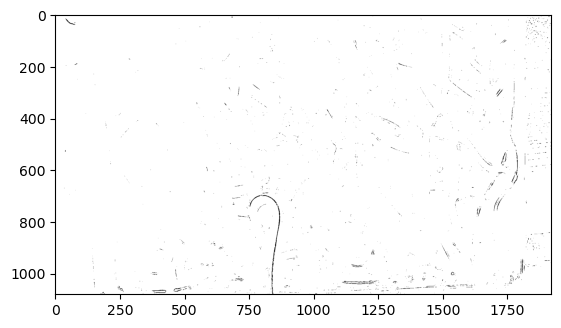

In [3]:
bin = cv2.adaptiveThreshold(image, 63, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, blockSize=11, C=10)
plt.imshow(bin, cmap='gray')
bin.dtype

In [4]:
mask = np.invert(bin.astype(bool))
mask.sum()

10488

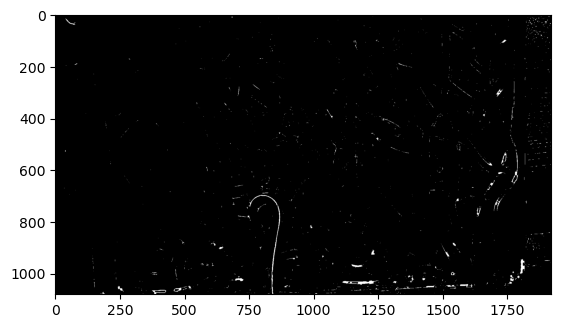

In [5]:
# morphological operations:

tmp = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5)))
# tmp = cv2.morphologyEx(tmp, cv2.MORPH_OPEN, np.ones((3, 3)))
plt.imshow(tmp, cmap='gray')

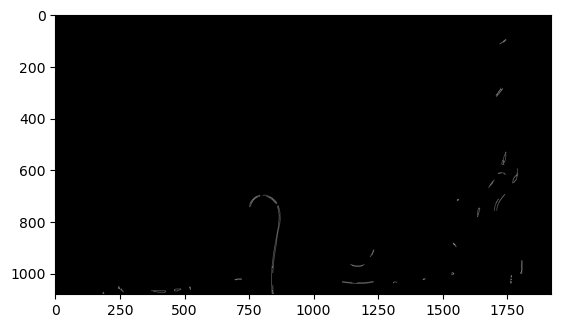

In [6]:
# Gradient-based: Guidewire has strong gradient
l = cv2.Laplacian(image, cv2.CV_64F)
sx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
sy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
c = cv2.Canny(image, 100, 400)
# plt.imshow(np.abs(l), cmap='gray')
# plt.imshow(np.abs(sy + sx), cmap='gray')
plt.imshow(c, cmap='gray')

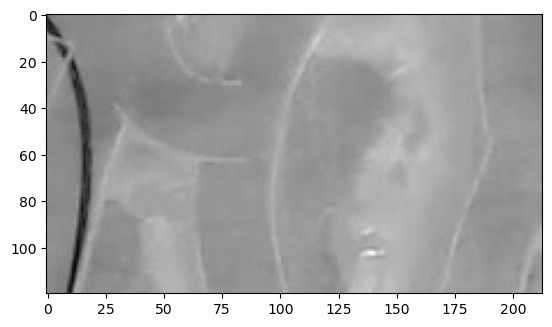

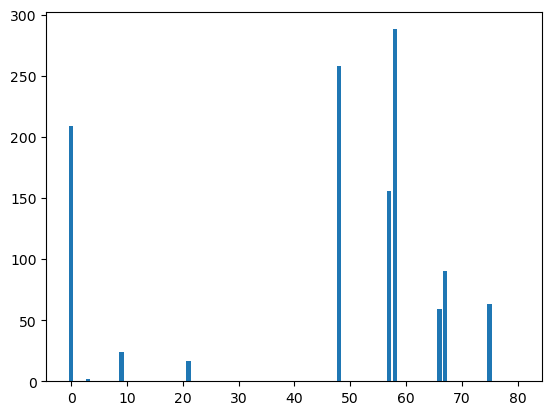

In [32]:
# Do patched canny to supress brighter region gradient
from skimage.util import view_as_windows

def image_patch(image, patch_size=10):
    patch_w = image.shape[1] // patch_size
    patch_h = image.shape[0] // patch_size
    patches = np.zeros((patch_size, patch_size, patch_h, patch_w), dtype=np.uint8)
    for i in range(patch_size):
        for j in range(patch_size):
            patches[i, j] = image[i * patch_h: (i + 1) * patch_h, j * patch_w: (j + 1) * patch_w]       
    return np.array(patches), patch_w, patch_h



def patch_canny(image, patch_size=9, threshold1=100, threshold2=400, drop_intensity_thresh=100, drop_size=100):
    patches, patch_w, patch_h = image_patch(image, patch_size)
    canny = np.zeros_like(image)
    inspect = []
    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            inspect.append((patches[i, j] < drop_intensity_thresh).sum())
            area_size = (patches[i, j] < drop_intensity_thresh).sum()
            if area_size > drop_size:
                canny[i * patch_h: (i + 1) * patch_h, j * patch_w: (j + 1) * patch_w] = cv2.Canny(patches[i, j], threshold1, threshold2)
    plt.imshow(patches[np.argmax(inspect)//patch_size, np.argmax(inspect)%patch_size], cmap='gray')
    plt.figure(2)
    plt.bar(range(len(inspect)), inspect)
    return canny

patched_canny = patch_canny(image, patch_size=9, threshold1=50, threshold2=300, drop_intensity_thresh=70,drop_size=50)




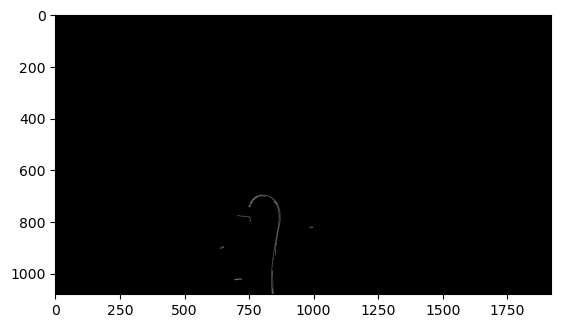

In [33]:
plt.imshow(patched_canny, cmap='gray')

In [ ]:
# Supress gradient in bright region by modifying gradient selection process in canny
def canny_with_hueristic(image, threshold1, threshold2, ksize=5):
    blurred = cv2.GaussianBlur(image, (ksize, ksize), 0)